<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

2025-09-29 18:57:13.455862: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-29 18:57:13.461759: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-29 18:57:13.660010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-29 18:57:14.740490: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

### Datos
Como fuente de datos de utilizarán las novelas de "A Song of Ice and Fire" de George Martin, utilizadas durante el Desafío 2. Las mismas fueron obtenidas de Kaggle:
https://www.kaggle.com/datasets/saurabhbadole/game-of-thrones-book-dataset/data

El dataset cotiene cinco archivos de texto, cada uno con un libro de la saga. En base a las pruebas realizadas se decide utilizar únicamente la primera novela, para evitar que el tiempo de entrenamiento se vuelva demasiado largo:

In [2]:
import os

lista_libros = [
    "1 - A Game of Thrones.txt"]

# Crear un corpus en memoria
corpus = ""

for nombre in lista_libros:
    ruta_libro = os.path.join("./Dataset", nombre)
    with open(ruta_libro, "r", encoding="latin-1") as f:
        contenido = f.read()
        corpus += contenido + "\n"  # agrega un salto de línea entre libros

Removemos los encabezados que no forman parte de las novelas:

In [3]:
import re 

#Eliminar encabezados no deseados
import re

patterns_to_remove = [
    r"a game of thrones",
    r"a clash of kings",
    r"a storm of swords",
    r"a feast for crows",
    r"a dance with dragons",
    r"book [^\n]+",          # líneas tipo "Book One of..."
    r"by george r\. r\. martin",
    r"prologue",
    r"dedication",
    r"contents",
    r"a note on chronology",
    r"a cavil on chronology",
    r"version history.*",
    r"page \d+",             # "Page XX"
    r"[\n\r\t]+",            # saltos de línea, retorno de carro, tabulaciones
    r"[^\x20-\x7E]+"         # caracteres no ASCII imprimibles
]

for pat in patterns_to_remove:
    corpus = re.sub(pat, " ", corpus, flags=re.IGNORECASE)

# Reemplazar múltiples espacios por uno solo y recortar inicio/final
corpus = re.sub(r"\s+", " ", corpus).strip()

In [4]:
# En corpus se encuentra el texto
corpus[:1000]

'"We should start back," Gared urged as the woods began to grow dark around them. "The wildlings are dead." "Do the dead frighten you?" Ser Waymar Royce asked with just the hint of a smile. Gared did not rise to the bait. He was an old man, past fifty, and he had seen the lordlings come and go. "Dead is dead," he said. "We have no business with the dead." "Are they dead?" Royce asked softly. "What proof have we?" "Will saw them," Gared said. "If he says they are dead, that\'s proof enough for me." Will had known they would drag him into the quarrel sooner or later. He wished it had been later rather than sooner. "My mother told me that dead men sing no songs," he put in. "My wet nurse said the same thing, Will," Royce replied. "Never believe anything you hear at a woman\'s tit. There are things to be learned even from the dead." His voice echoed, too loud in the twilit forest. "We have a long ride before us," Gared pointed out. "Eight days, maybe nine. And night is falling." Ser Waymar

Debido a que el tamaño del libro completo vuelve el entrenamiento excesivamente lento, tomamos el primer tercio del libro:

In [5]:
long_texto = len(corpus)
long_texto_considerar = long_texto//3

corpus = corpus[:long_texto_considerar]

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [6]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [7]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [8]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(corpus)

In [9]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

72

In [10]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [11]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in corpus]

In [12]:
tokenized_text[:1000]

[30,
 5,
 1,
 24,
 31,
 48,
 3,
 2,
 70,
 38,
 24,
 31,
 40,
 61,
 0,
 40,
 24,
 29,
 61,
 39,
 71,
 43,
 30,
 24,
 11,
 61,
 0,
 1,
 38,
 24,
 2,
 0,
 17,
 1,
 38,
 24,
 61,
 31,
 24,
 40,
 48,
 1,
 24,
 22,
 3,
 3,
 38,
 31,
 24,
 29,
 1,
 17,
 61,
 9,
 24,
 40,
 3,
 24,
 17,
 0,
 3,
 22,
 24,
 38,
 61,
 0,
 71,
 24,
 61,
 0,
 3,
 2,
 9,
 38,
 24,
 40,
 48,
 1,
 50,
 6,
 24,
 30,
 49,
 48,
 1,
 24,
 22,
 60,
 70,
 38,
 70,
 60,
 9,
 17,
 31,
 24,
 61,
 0,
 1,
 24,
 38,
 1,
 61,
 38,
 6,
 30,
 24,
 30,
 58,
 3,
 24,
 40,
 48,
 1,
 24,
 38,
 1,
 61,
 38,
 24,
 42,
 0,
 60,
 17,
 48,
 40,
 1,
 9,
 24,
 7,
 3,
 2,
 28,
 30,
 24,
 62,
 1,
 0,
 24,
 5,
 61,
 7,
 50,
 61,
 0,
 24,
 67,
 3,
 7,
 39,
 1,
 24,
 61,
 31,
 71,
 1,
 38,
 24,
 22,
 60,
 40,
 48,
 24,
 14,
 2,
 31,
 40,
 24,
 40,
 48,
 1,
 24,
 48,
 60,
 9,
 40,
 24,
 3,
 42,
 24,
 61,
 24,
 31,
 50,
 60,
 70,
 1,
 6,
 24,
 11,
 61,
 0,
 1,
 38,
 24,
 38,
 60,
 38,
 24,
 9,
 3,
 40,
 24,
 0,
 60,
 31,
 1,
 24,
 40,
 3,
 24,
 40,
 4

### Organizando y estructurando el dataset

In [13]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [14]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [15]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [16]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [17]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [18]:
X.shape

(474595, 100)

In [19]:
X[0,:10]

array([30,  5,  1, 24, 31, 48,  3,  2, 70, 38])

In [20]:
y[0,:10]

array([ 5,  1, 24, 31, 48,  3,  2, 70, 38, 24])

In [21]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

### RNN simple

In [22]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [23]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/home/agustin/Desktop/CEIA UBA/Procesamiento Lenguaje Natural I/CEIA-ProcesamientoLenguajeNaturalI/.venv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
E0000 00:00:1759183039.144836    5810 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1759183039.151864    5810 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 72)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        54,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 72)       │        14,472 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,072 (269.81 KB)

 Trainable params: 69,072 (269.81 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [40]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, model_name, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data
      self.model_name = model_name
      self.target = []
      self.padded = []
      self.history_ppl = history_ppl

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_name)
          print(f"Saved new model as {self.model_name}")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [41]:
from keras.models import load_model


model_name = "model_rnn.keras"
history_name = "history_ppl_rnn.npy"

if os.path.exists(model_name) and os.path.exists(history_name):
    print(f"El modelo {model_name} y el historial {history_name} ya existen. Cargando...")
    model = load_model(model_name)
    history_ppl = np.load(history_name).tolist()
else:
    print("Entrenando modelo nuevo...")
    # En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
    history_ppl = []

    ppl_cb = PplCallback(tokenized_sentences_val, model_name,
                         history_ppl)

    hist = model.fit(
        X, y,
        epochs=20,
        batch_size=512,
        callbacks=[ppl_cb]
    )

    # guardamos history_ppl al final del entrenamiento
    np.save(history_name, np.array(history_ppl))
    print(f"Saved history as {history_name}")

El modelo model_rnn.keras y el historial history_ppl_rnn.npy ya existen. Cargando...


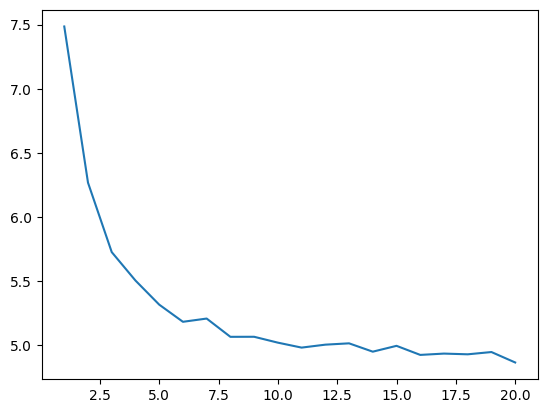

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

### LSTM

In [43]:
from keras.layers import LSTM
model_lstm = Sequential()

model_lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_lstm.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_lstm.summary()

/home/agustin/Desktop/CEIA UBA/Procesamiento Lenguaje Natural I/CEIA-ProcesamientoLenguajeNaturalI/.venv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 72)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 200)      │       218,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 72)       │        14,472 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,872 (909.66 KB)

 Trainable params: 232,872 (909.66 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model_lstm_name = "model_lstm.keras"
history_lstm_name = "history_ppl_lstm.npy"

if os.path.exists(model_lstm_name) and os.path.exists(history_lstm_name):
    print(f"El modelo {model_lstm_name} y el historial {history_lstm_name} ya existen. Cargando...")
    model_lstm = load_model(model_lstm_name)
    history_ppl_lstm = np.load(history_lstm_name).tolist()
else:
    print("Entrenando modelo nuevo...")
    # En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
    history_ppl_lstm = []

    ppl_cb_lstm = PplCallback(tokenized_sentences_val, model_lstm_name,
                         history_ppl_lstm)

    hist_lstm = model_lstm.fit(
        X, y,
        epochs=20,
        batch_size=512,
        callbacks=[ppl_cb_lstm]
    )

    # guardamos history_ppl al final del entrenamiento
    np.save(history_lstm_name, np.array(history_ppl_lstm))
    print(f"Saved history as {history_lstm_name}")

El modelo model_lstm.keras y el historial history_ppl_lstm.npy ya existen. Cargando...


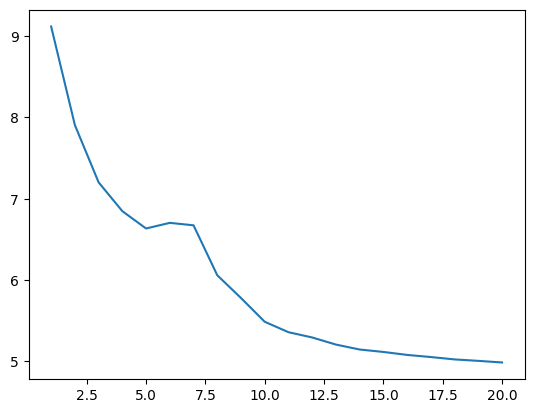

In [45]:
epoch_count = range(1, len(history_ppl_lstm) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_lstm)
plt.show()


### GRU

In [46]:
from keras.layers import GRU
model_lstm = Sequential()

model_gru = Sequential()

model_gru.add(TimeDistributed(
    CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
    input_shape=(None, 1))
)

model_gru.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_gru.add(Dense(vocab_size, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop'
)

model_gru.summary()

/home/agustin/Desktop/CEIA UBA/Procesamiento Lenguaje Natural I/CEIA-ProcesamientoLenguajeNaturalI/.venv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, None, 72)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 200)      │       164,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 72)       │        14,472 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,872 (698.72 KB)

 Trainable params: 178,872 (698.72 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model_gru_name = "model_gru.keras"
history_gru_name = "history_ppl_gru.npy"

if os.path.exists(model_gru_name) and os.path.exists(history_gru_name):
    print(f"El modelo {model_gru_name} y el historial {history_gru_name} ya existen. Cargando...")
    model_gru = load_model(model_gru_name)
    history_ppl_gru = np.load(history_gru_name).tolist()
else:
    print("Entrenando modelo nuevo...")
    # En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
    history_ppl_gru = []

    ppl_cb_gru = PplCallback(tokenized_sentences_val, model_gru_name,
                         history_ppl_gru)

    hist_gru = model_gru.fit(
        X, y,
        epochs=20,
        batch_size=512,
        callbacks=[ppl_cb_gru]
    )

    # guardamos history_ppl al final del entrenamiento
    np.save(history_gru_name, np.array(history_ppl_gru))
    print(f"Saved history as {history_gru_name}")

Entrenando modelo nuevo...
Epoch 1/20
927/927 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 2.6424
 mean perplexity: 7.48253862853349 

Saved new model as model_gru.keras
927/927 ━━━━━━━━━━━━━━━━━━━━ 278s 297ms/step - loss: 2.3280
Epoch 2/20
927/927 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 1.9633
 mean perplexity: 6.108283084160944 

Saved new model as model_gru.keras
927/927 ━━━━━━━━━━━━━━━━━━━━ 261s 281ms/step - loss: 1.9031
Epoch 3/20
927/927 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 1.7595
 mean perplexity: 5.399801442198314 

Saved new model as model_gru.keras
927/927 ━━━━━━━━━━━━━━━━━━━━ 258s 279ms/step - loss: 1.7254
Epoch 4/20
927/927 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 1.6400
 mean perplexity: 5.059296184956781 

Saved new model as model_gru.keras
927/927 ━━━━━━━━━━━━━━━━━━━━ 258s 278ms/step - loss: 1.6184
Epoch 5/20
927/927 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 1.5649
 mean perplexity: 4.879656712062495 

Saved new model as model_gru.keras
927/927 ━━━━━━━━━━━━━━━━

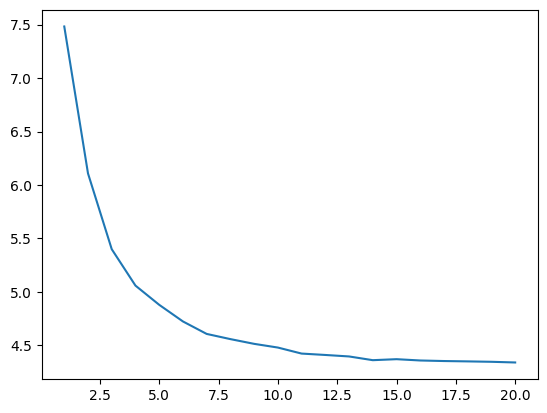

In [48]:
epoch_count = range(1, len(history_ppl_gru) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_gru)
plt.show()



### Predicción del próximo caracter

In [58]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Created dataset file at: .gradio\flagged\dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [59]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [67]:
input_text='Jaime Lann'

generate_seq(model, input_text, max_length=max_context_size, n_words=50)

'Jaime Lannister said. "It was not see the stories and strong'

###  Beam search y muestreo aleatorio

In [68]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [69]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [70]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=50,input=input_text)

In [71]:
salidas[0]

array([58,  3,  4,  1, 33, 60, 47,  3, 57, 57,  4, 68, 65, 33, 61, 60, 47,
        3, 57, 57,  4, 68, 65, 33, 61, 60, 68,  3,  4, 40, 45, 60, 16, 11,
       46,  3, 65, 60, 34,  3, 68, 60, 65, 46, 33, 21, 60, 34, 33, 61, 33,
       60, 34,  3, 68, 60, 57, 10, 65, 60])

In [72]:
# veamos las salidas
decode(salidas[0])

'Jaime Lannister Lannister said. "What was they were was not '